In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tabulate import tabulate
from IPython.display import display, HTML
# from google.colab import files
import io
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
!pip install -U lazyme
from lazyme.string import color_print
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
!pip install scikit-plot
import scikitplot as skplt
import matplotlib as mpl
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")
sns.set_style('whitegrid')

Requirement already up-to-date: lazyme in c:\users\dell\anaconda3\lib\site-packages (0.0.27)


In [ ]:
def upload_df(data_path):

    df = pd.read_csv(data_path)
    try: 
        df.drop('Unnamed: 0', axis=1, inplace=True)
    except:
        pass
    display(HTML(df.head().to_html()))
    return df

In [ ]:
df_md = upload_df(r'./Dataset/classification_data.csv')

,Snapshot Date,Checkin Date,DayDiff,Hotel Name,WeekDay,DiscountPerc,Discount Code
0,0.0,0.0,1,0.403255,0.333333,2.375156,2
1,0.0,0.0,1,0.477396,0.333333,1.795402,2
2,0.0,0.0,1,0.591320,0.333333,2.579217,2
3,0.0,0.0,1,0.616637,0.333333,0.994252,2
4,0.0,0.0,1,0.652803,0.333333,2.956512,1


## **training the classification models**.

In [ ]:
# Split the data to training set and test set (70%, 30%)
features = list(df_md.drop('Discount Code', axis = 1, inplace = False))
y = df_md["Discount Code"]
X = df_md[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [ ]:
class ParamHolder:

    def __init__(self):
        self.acc_s = []        # holds the histoey of acc_splitter | tree
        self.acc_md = []       # holds the histoey of acc_max_depth | tree | forest | xgboost | extra tree
        self.acc_mss = []      # holds the histoey of acc_min_samples_split | tree | forest | extra tree
        self.acc_msl = []      # holds the histoey of acc_min_samples_leaf | tree | forest | extra tree
        self.acc_mwfl = []     # holds the histoey of acc_min_weight_fraction_leaf | tree | forest | extra tree
        self.acc_mf = []       # holds the histoey of acc_max_features | tree | forest | extra tree
        self.acc_mln = []      # holds the histoey of acc_max_leaf_nodes | tree | forest | extra tree
        self.acc_mid = []      # holds the histoey of acc_min_impurity_decrease | tree | forest |extra tree
        self.acc_mis = []      # holds the histoey of acc_min_impurity_split | tree | forest | extra tree
        self.acc_cw = []       # holds the histoey of acc_class_weight | tree | forest | extra tree
        self.acc_ca = []       # holds the histoey of acc_ccp_alpha | tree
        self.acc_c = []        # holds the histoey of acc_criterion | forest | extra tree
        self.acc_ne = []       # holds the histoey of acc_n_estimators | forest | xgboost | extra tree
        self.acc_os = []       # holds the histoey of acc_oob_score | forest | extra tree
        self.acc_ws = []       # holds the histoey of acc_warm_start | forest | extra tree
        self.acc_ms = []       # holds the histoey of acc_cc max_samples | forest | extra tree
        self.acc_bs = []       # holds the histoey of acc_booster | xgboost
        self.acc_lr = []       # holds the histoey of acc_learning_rate | xgboost
        self.acc_mslo = []     # holds the histoey of acc_min_split_loss | xgboost
        self.acc_mcw = []      # holds the histoey of acc_min_child_weight | xgboost
        self.acc_cbt = []      # holds the histoey of acc_colsample_bytree | xgboost        
        self.acc_nn = []       # holds the histoey of acc_n_neighbors | knn
        self.acc_w = []        # holds the histoey of acc_weights | knn
        self.acc_a = []        # holds the histoey of acc_algorithm | knn
        self.acc_ls = []       # holds the histoey of acc_leaf_size | knn
        self.acc_p = []        # holds the histoey of acc_p | knn
        self.best_p = {}       # holds the best parms any classifire (Each has the appropriate parameters) 


def best_param(clf, tph_arr, set_param, params): 
    tph_best = {}
    max_score = 0
    for i in params: 
        clf.set_params(**{set_param:i})
        clf = clf.fit(X_train, y_train)
        acc = accuracy_score(y_test,clf.predict(X_test))
        tph_arr.append(acc)
        if acc > max_score:
            max_score = accuracy_score(y_test, clf.predict(X_test))
            tph_best[set_param] = i

    return tph_best

In [ ]:
######################## A number of functions that help us get the best parameters for DecisionTreeClassifier ########################
tph_attrs = ['acc_s','acc_md','acc_mss','acc_msl','acc_mwfl','acc_mf','acc_mln','acc_mid','acc_mis','acc_cw','acc_ca']      
set_tree_params = ['splitter','max_depth','min_samples_split','min_samples_leaf','min_weight_fraction_leaf','max_features',
              'max_leaf_nodes','min_impurity_decrease','min_impurity_split','class_weight','ccp_alpha']
params_range_tree = [['best','random'],[x for x in range(1, 40)],[x for x in range(2, 100, 8)],
              [x for x in range(1, 10, 10)],[0.0, 0.1, 0.2, 0.5],['auto', 'sqrt', 'log2']+ [None],
              [x for x in range(2, 20, 4)] + [None],[0.0, 0.1, 0.2, 0.5],[0.0,0.00005,0.0001,0.0002,0.0005,0.001,0.0015,0.01],
              ['balanced', None],[0.0, 0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.0015, 0.002, 0.005, 0.01]]

def best_tree_params(clf_criterion):

    tph = ParamHolder()
    for i in range(len(set_tree_params)): 
        tph.best_p.update(best_param(DecisionTreeClassifier(criterion = clf_criterion), 
                          getattr(tph,tph_attrs[i]),set_tree_params[i],params_range_tree[i])) 
    return tph
########################################################################################################################################

######################## A number of functions that help us get the best parameters for RandomForestClassifier #########################
fph_attrs = ['acc_c','acc_ne','acc_md','acc_mss','acc_msl','acc_mwfl','acc_mf','acc_mln','acc_mid','acc_mis',
             'acc_os','acc_cw','acc_ws','acc_ms']      
set_forest_params = ['criterion','n_estimators','max_depth','min_samples_split','min_samples_leaf','min_weight_fraction_leaf',
                     'max_features','max_leaf_nodes','min_impurity_decrease','min_impurity_split','oob_score',
                     'class_weight','warm_start','max_samples']
params_range_forest = [['gini','entropy'],[x for x in range(35, 100, 10)],[x for x in range(1, 30, 10)]+[None],
              [x for x in range(2, 40, 10)],[x for x in range(1, 10, 3)],[0.0, 0.2, 0.5],['auto', 'sqrt', 'log2'],
              [x for x in range(2, 20, 8)] + [None],[0.0, 0.2, 0.5],[0.0,0.00005]+[None],[True,False],
              ['balanced','balanced_subsample', None],[True,False],[x for x in range(2, 40, 10)] + [None]]

def best_forest_params():

    fph = ParamHolder()
    for i in range(len(set_forest_params)):    
        fph.best_p.update(best_param(RandomForestClassifier(), 
                          getattr(fph,fph_attrs[i]),set_forest_params[i],params_range_forest[i])) 
    return fph
#######################################################################################################################################

######################## A number of functions that help us get the best parameters for XGBClassifier #################################
xph_attrs = ['acc_bs','acc_lr','acc_ne','acc_md','acc_mslo','acc_mcw','acc_cbt']      
set_xgboot_params = ['booster','learning_rate','n_estimators','max_depth','min_split_loss','min_child_weight','colsample_bytree']
params_range_xgboost = [['gbtree'],[0.1, 0.2, 0.3, 0.5, 0.7],[x for x in range(40, 100, 15)],
                        [x for x in range(6, 20, 8)],[x for x in range(0, 5, 3)],[0.01, 0.05, 0.5,0.99,1,3,10],[1, 0.8, 0.5]]

def best_xgboost_params():

    xph = ParamHolder()
    for i in range(len(set_xgboot_params)): 
        xph.best_p.update(best_param(XGBClassifier(), 
                          getattr(xph,xph_attrs[i]),set_xgboot_params[i],params_range_xgboost[i]))
    return xph
#########################################################################################################################################

######################## A number of functions that help us get the best parameters for ExtraTreesClassifier ############################
eph_attrs = ['acc_c','acc_ne','acc_md','acc_mss','acc_msl','acc_mwfl','acc_mf','acc_mln','acc_mid','acc_mis'
             ,'acc_cw','acc_ws','acc_ms']     
set_extrat_params = ['criterion','n_estimators','max_depth','min_samples_split','min_samples_leaf','min_weight_fraction_leaf',
                     'max_features','max_leaf_nodes','min_impurity_decrease','min_impurity_split','class_weight','warm_start',
                     'max_samples']
params_range_extrat = [['gini','entropy'],[x for x in range(35, 100, 15)],[x for x in range(1, 15, 7)]+[None],
              [x for x in range(2, 20, 5)],[x for x in range(1, 10, 3)],[0.0, 0.2],['auto', 'sqrt', 'log2'],
              [x for x in range(2, 20, 8)] + [None],[0.0, 0.2],[0.0,0.005]+[None],['balanced','balanced_subsample', None],
              [True,False],[x for x in range(2, 40, 10)] + [None]]

def best_etc_params():
  
    eph = ParamHolder()
    for i in range(len(set_extrat_params)):        
        eph.best_p.update(best_param(ExtraTreesClassifier(), 
                          getattr(eph,eph_attrs[i]),set_extrat_params[i],params_range_extrat[i])) 
    return eph
##########################################################################################################################################

######################## A number of functions that help us get the best parameters for KNeighborsClassifier #############################
kph_attrs = ['acc_nn','acc_w','acc_a','acc_ls','acc_p']      
set_knn_params = ['n_neighbors','weights','algorithm','leaf_size','p']
params_range_knn = [[x for x in range(1, 10, 2)],['uniform','distance'],['auto','ball_tree','kd_tree','brute'],
              [x for x in range(10, 40, 10)],[x for x in range(1, 5, 1)]]

def best_knn_params():

    kph = ParamHolder()
    for i in range(len(set_knn_params)):        
        kph.best_p.update(best_param(KNeighborsClassifier(), 
                          getattr(kph,kph_attrs[i]),set_knn_params[i],params_range_knn[i])) 
    return kph
###########################################################################################################################################

In [ ]:
########################################## Several functions for different Classification  models. ########################################

class Score:
    auccuracy = 0.0
    recall = 0.0
    precision = 0.0
    roc = 0.0

class Classifier:
    name = ''
    clf = None
    y_pred = None
    conf_mat = None

    def __init__(self, name):
        self.name = name
        self.score = Score()
        self.ph = ParamHolder()

results_map = {}

def get_best_clf(clf_criterion):
    result = Classifier(clf_criterion)
    if clf_criterion == 'gini' or clf_criterion == 'entropy':
        result.ph = best_tree_params(clf_criterion)
        clf = DecisionTreeClassifier(criterion=clf_criterion,**result.ph.best_p)
    elif clf_criterion == 'random forest':
        result.ph = best_forest_params()
        clf = RandomForestClassifier(**result.ph.best_p)
    elif clf_criterion == 'XGBoost':
        result.ph = best_xgboost_params() 
        clf = XGBClassifier(**result.ph.best_p) 
    elif clf_criterion == 'Extra Trees Classifier':
        result.ph = best_etc_params()
        clf = ExtraTreesClassifier(**result.ph.best_p)
    elif clf_criterion == 'KNeighborsClassifier':
        result.ph = best_knn_params()
        clf = KNeighborsClassifier(**result.ph.best_p) 
    elif clf_criterion == 'naive_bayes':
        clf = GaussianNB()
    # calculate a few score methods
    result.score.auccuracy = np.mean(cross_val_score(clf, X_train, y_train, scoring='accuracy', cv=5))           
    result.clf = clf = clf.fit(X_train, y_train)
    result.y_pred = y_pred = clf.predict(X_test) 
    result.conf_mat = confusion_matrix(y_test, y_pred)
    result.score.recall = recall_score(y_test, y_pred, average='weighted')
    result.score.precision = precision_score(y_test, y_pred, average='weighted')
    result.score.roc = roc_auc_score(y_test, result.clf.predict_proba(X_test), multi_class="ovo")  
    return result

def print_influence_graph(classifier):
    # The parameters that most influenced the decision. * Part III on this algo
    feature_imp = pd.Series(classifier.clf.feature_importances_,index=features).sort_values(ascending=False)
    sns.barplot(x=feature_imp, y=feature_imp.index)
    # Add labels to your graph
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title(classifier.name.upper() +" - Visualizing Important Features")
    plt.show()

def print_confusion_matrix(classifier):
    sns.heatmap(classifier.conf_mat.T, square=True, annot=True, fmt='d', cbar=False,
                xticklabels=np.unique(classifier.y_pred), yticklabels=np.unique(classifier.y_pred))
    plt.xlabel('True')
    plt.ylabel('Predicted'); 

def print_few_methods_score(classifier):
    # Print score methodes. * Part IV on this algo
    mat = classifier.conf_mat
    FP = mat.sum(axis=0) - np.diag(mat)
    FN = mat.sum(axis=1) - np.diag(mat)
    TP = np.diag(mat)
    TN = mat.sum() - (FP + FN + TP)
    print("FP '(false positive)' " + classifier.name.upper() + ' = ', FP)
    print("FN '(false negative)' " + classifier.name.upper() + ' = ', FN)
    print("TP '(true positive)' " + classifier.name.upper() + ' = ', TP)
    print("TN '(true negative)' " + classifier.name.upper() + ' = ', TN)
    print('Accuracy score for ' + classifier.name.upper() + ' = ', classifier.score.auccuracy)
    print('Recall for ' + classifier.name.upper() + ' = ', classifier.score.recall)
    print('Precision for ' + classifier.name.upper() + ' = ', classifier.score.precision) 
    print("ROC for " + classifier.name.upper() + ' = ', classifier.score.roc) 

def print_roc_curves(classifier):
    # Show ROC Curves. * Part IV on this algo
    skplt.metrics.plot_roc(y_test, classifier.clf.predict_proba(X_test))
    plt.title('ROC Curves for ' + classifier.name.upper())
    plt.show() 

#########################################################################################################################################

### **Decision Tree**

#####    **criterion = 'gini'**

In [ ]:
results_map['gini'] = clf_gini = get_best_clf('gini')

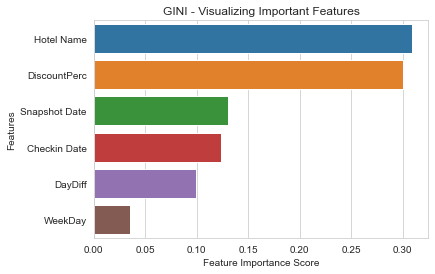

In [ ]:
print_influence_graph(clf_gini)

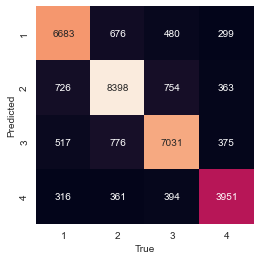

In [ ]:
print_confusion_matrix(clf_gini)

FP '(false positive)' GINI =  [1455 1843 1668 1071]
FN '(false negative)' GINI =  [1559 1813 1628 1037]
TP '(true positive)' GINI =  [6683 8398 7031 3951]
TN '(true negative)' GINI =  [22403 20046 21773 26041]
Accuracy score for GINI =  0.7821570626112873
Recall for GINI =  0.8119314641744548
Precision for GINI =  0.8119852143549031
ROC for GINI =  0.872896972184726


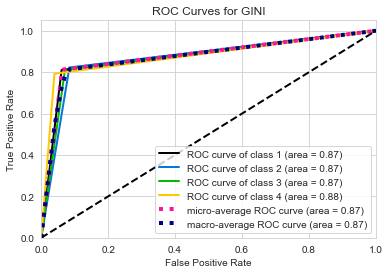

In [ ]:
print_few_methods_score(clf_gini)
print_roc_curves(clf_gini)

##### **Conclusions for decision tree type gini.**
*   The accuracy ROC, Recall, Precision, scores are relatively good.

*   The most influential parameter in the decision is discount price and the name of the hotel and it also conforms to the logic that a discount is in accordance with the policy of each hotel.

* For the parameters within the algorithm itself we found that the parameter that most affects the result is the **depth of the tree** the other parameters do not affect to such an extent that it is worth changing them and therefore most of them remained in the default state.

* In **Conclusions** we explain the significance of the results of the statistical indices.

* When it comes to decision trees then the big concern is from overfitting it is impossible to say with certainty that we do not have this problem but since the amount of data is very large and we run at a reasonable size relative to the data size and the results of the algorithm are not very unusual then probably we dnot have this problem [at least not in an unusual way for decision trees].



#####    **criterion = 'entropy'**

In [ ]:
results_map['entropy'] = clf_entropy = get_best_clf('entropy')

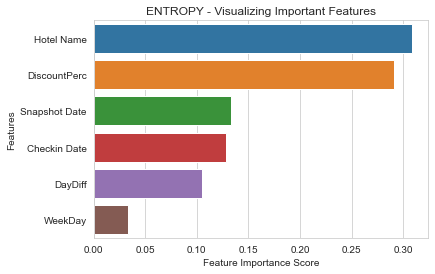

In [ ]:
# The parameters that most influenced the decision. * Part III on this algo
print_influence_graph(clf_entropy)

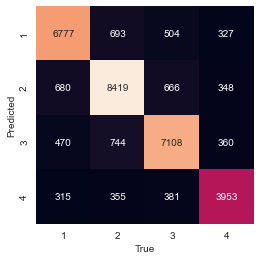

In [ ]:
# Print FP, FN, TP, TN. * Part IV on this algo
print_confusion_matrix(clf_entropy)

FP '(false positive)' ENTROPY =  [1524 1694 1574 1051]
FN '(false negative)' ENTROPY =  [1465 1792 1551 1035]
TP '(true positive)' ENTROPY =  [6777 8419 7108 3953]
TN '(true negative)' ENTROPY =  [22334 20195 21867 26061]
Accuracy score for ENTROPY =  0.7876178265058398
Recall for ENTROPY =  0.8179750778816199
Precision for ENTROPY =  0.8180357175556674
ROC for ENTROPY =  0.8766894802728039


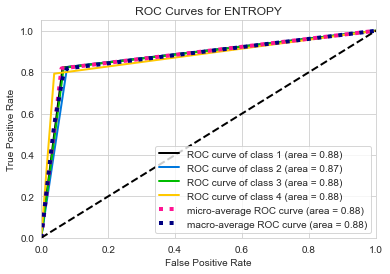

In [ ]:
print_few_methods_score(clf_entropy)
print_roc_curves(clf_entropy)

##### **Conclusions for decision tree type entropy.**
The conclusion for this entropy tree is very similar to the conclusion of the gini decision tree and the results of their algorithms are almost exactly the same.

### **Random Forest**

In [ ]:
results_map['random forest'] = clf_rf = get_best_clf('random forest')

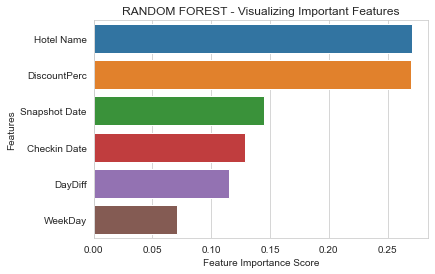

In [ ]:
# The parameters that most influenced the decision. * Part III on this algo
# Creating a bar plot
print_influence_graph(clf_rf)

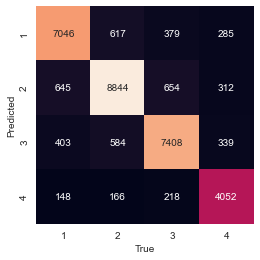

In [ ]:
# Print FP, FN, TP, TN. * Part IV on this algo
print_confusion_matrix(clf_rf)

FP '(false positive)' RANDOM FOREST =  [1281 1611 1326  532]
FN '(false negative)' RANDOM FOREST =  [1196 1367 1251  936]
TP '(true positive)' RANDOM FOREST =  [7046 8844 7408 4052]
TN '(true negative)' RANDOM FOREST =  [22577 20278 22115 26580]
Accuracy score for RANDOM FOREST =  0.8257629680217191
Recall for RANDOM FOREST =  0.8520249221183801
Precision for RANDOM FOREST =  0.8524976266584662
ROC for RANDOM FOREST =  0.9647680711451433


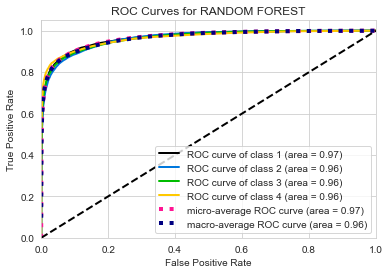

In [ ]:
print_few_methods_score(clf_rf)
print_roc_curves(clf_rf)

##### **Conclusions for random forest classifier.**
*  The accuracy ROC, Recall, Precision, scores are very good.

*   The most influential parameters in the decision is discount price and the name of the hotel and it also conforms to the logic that a discount is in accordance with the policy of each hotel.

*   For the parameters within the algorithm itself we found that the parameter that most affects the result is the **n_estimators**. In addition, we noticed that when **oob_score equals TRUE**, slightly better results are obtained, the other parameters do not affect to such an extent that it is worth changing them and therefore most of them remained in the default state.

* In the **Conclusions** part we explain the significance of the results of the statistical indices.

* We took a reasonable range of estimators because we did not want it to be overfitting.

### **Naïve Bayes**

In [ ]:
results_map['Naive Bayes'] = clf_gnb = get_best_clf('naive_bayes')

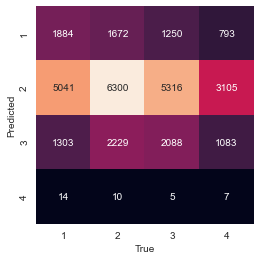

In [ ]:
# Print FP, FN, TP, TN. * Part IV on this algo
print_confusion_matrix(clf_gnb)

FP '(false positive)' NAIVE_BAYES =  [ 3715 13462  4615    29]
FN '(false negative)' NAIVE_BAYES =  [6358 3911 6571 4981]
TP '(true positive)' NAIVE_BAYES =  [1884 6300 2088    7]
TN '(true negative)' NAIVE_BAYES =  [20143  8427 18826 27083]
Accuracy score for NAIVE_BAYES =  0.3187534671370359
Recall for NAIVE_BAYES =  0.3202180685358255
Precision for NAIVE_BAYES =  0.302047627398594
ROC for NAIVE_BAYES =  0.5559973138910878


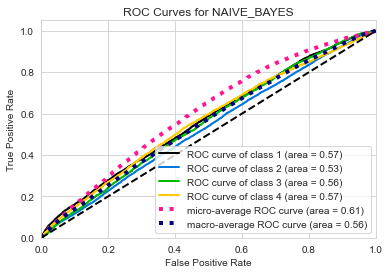

In [ ]:
print_few_methods_score(clf_gnb)
print_roc_curves(clf_gnb)

##### **Conclusions for Naive Bayes classifier.**
*   The accuracy ROC, Recall, Precision, scores are very bad.

* For the parameters within the algorithm itself it has no parameters that helped us get better results so we stayed in the deflated state. [We will try to run it again after resampling is done to see how it affects its results].

* In the **Conclusions** part we explain the significance of the results of the statistical indices.

### **XGBoost**

In [ ]:
!pip3 install xgboost
from xgboost import XGBClassifier

In [ ]:
results_map['XGBoost'] = clf_xgb = get_best_clf('XGBoost')

[02:35:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:36:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:36:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:36:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[02:44:07] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:44:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[02:45:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


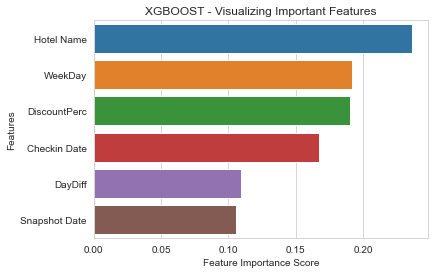

In [ ]:
print_influence_graph(clf_xgb)

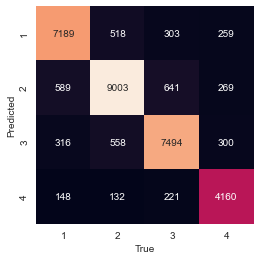

In [ ]:
print_confusion_matrix(clf_xgb)

FP '(false positive)' XGBOOST =  [1080 1499 1174  501]
FN '(false negative)' XGBOOST =  [1053 1208 1165  828]
TP '(true positive)' XGBOOST =  [7189 9003 7494 4160]
TN '(true negative)' XGBOOST =  [22778 20390 22267 26611]
Accuracy score for XGBOOST =  0.8396351848529197
Recall for XGBOOST =  0.8674766355140187
Precision for XGBOOST =  0.8678234494397485
ROC for XGBOOST =  0.9715598228627349


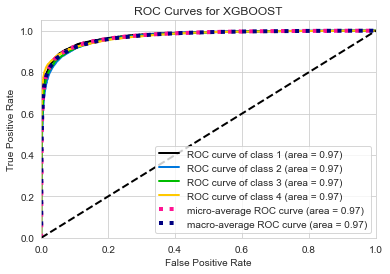

In [ ]:
print_few_methods_score(clf_xgb)
print_roc_curves(clf_xgb)

##### **Conclusions for XGBoost classifier.**
*  The accuracy ROC, Recall, Precision, scores are **Excellent**.

*   The most influential parameters in the decision are week day, and the name of the hotel. This algorithm went in a different direction from the other algorithms and found a connection between the day of the week of the checkin and the discount code. It makes some sense that for certain days the discount codes will be different from each other [midweek or weekend].

*   For the parameters within the algorithm itself we found that the parameter that most affects the result is the **n_estimators**. In addition, we noticed that when **max_depth around 20**, better results are obtained, the other parameters do not affect to such an extent that it is worth changing them and therefore most of them remained in the default state.

* In the **Conclusions** part we explain the significance of the results of the statistical indices.

* We took a reasonable range of **estimators and learning_rate** because we did not want it to be overfitting.

### **Neural network**
We built a network of neurons with 5 layers. 2 of which are the input output layers and the others are the inner layers of the network. The number of neurons in the first layer [input] is 6 as the number of features we have. The number of features in the output layer is 5 because we used the to_categorical function that turned the target class into vectors of 5 variables. The number of neurons in the inner layers was chosen after we tried to play with the parameters to get the best results.
We used the keras API because of the convenience it provides mainly for this type of data.
[You can run keras in google colab without installing anything or by installing keras in anaconda pormpt].

In [ ]:
!pip install keras
!pip install tensorflow

import keras
from keras.models import Sequential
from keras.layers import Dense
# from keras.utils import to_categorical 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
import IPython
!pip install -q -U keras-tuner
import kerastuner as kt

In [ ]:
# Now we will prepare our data for a neural network.
df_md_copy = df_md.copy()
features_n = list(df_md_copy.drop('Discount Code', axis = 1, inplace = False))
y_n = to_categorical(df_md_copy["Discount Code"])
X_n = df_md_copy[features]/df_md_copy[features].max()
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, test_size=0.30)
# lets see how our data look like In order to determine what
# size the output layer in the neural network will be.
print(y_test_n.shape[1])
print(y_test_n)

5
[[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]]


In [ ]:
METRICS = [
      keras.metrics.CategoricalAccuracy(name='accuracy'),
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      #keras.metrics.Precision(name='precision'),
      #keras.metrics.Recall(name='recall'),
      #keras.metrics.AUC(name='auc'),
]

def model_builder(hp):
  
    hp_units = hp.Int('units', min_value = 24, max_value = 1400, step = 48)
    # Create the model
    model = Sequential()
    model.add(Dense(units = hp_units, activation='relu', input_dim=6))
    model.add(Dense(units = hp_units, activation='relu'))
    model.add(Dense(units = hp_units, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    # Tune the learning rate for the optimizer 
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  
    model.compile(optimizer = keras.optimizers.Nadam(learning_rate = hp_learning_rate) ,
                loss='categorical_crossentropy', 
                metrics=METRICS)
  
    return model

In [ ]:
# We will now try to get the best parameters for the network.
tuner = kt.Hyperband(model_builder,objective = 'val_accuracy', max_epochs = 100,factor = 5,) 

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

INFO:tensorflow:Reloading Oracle from existing project .\untitled_project\oracle.json
INFO:tensorflow:Reloading Tuner from .\untitled_project\tuner0.json


In [ ]:
tuner.search(X_train_n, y_train_n, epochs = 100, validation_data = (X_test_n, y_test_n),
             callbacks = [ClearTrainingOutput()],batch_size=128)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 10 Complete [00h 28m 05s]
val_accuracy: 0.5123364329338074

Best val_accuracy So Far: 0.7266666889190674
Total elapsed time: 05h 05m 03s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 984 and the optimal learning rate for the optimizer
is 0.001.



In [ ]:
# Build the model with the optimal hyperparameters and train it on the data
def get_best_nn(clf_criterion):

    model = Classifier(clf_criterion)
    model.clf = tuner.hypermodel.build(best_hps)
    model.clf.fit(X_train_n, y_train_n, epochs = 100, validation_data = (X_test_n, y_test_n),batch_size=100)
    model.y_pred = model.clf.predict(X_test_n)
    model.conf_mat = confusion_matrix(np.argmax(y_test_n, axis=1), np.argmax(model.y_pred, axis=1)) 
    p = keras.metrics.Precision()
    p.update_state(y_test_n, model.y_pred)
    model.score.precision = p.result().numpy()
    a = keras.metrics.CategoricalAccuracy()
    a.update_state(y_test_n, model.y_pred)
    model.score.auccuracy = a.result().numpy()
    r = keras.metrics.Recall()
    r.update_state(y_test_n, model.y_pred)
    model.score.recall = r.result().numpy()
    ro = keras.metrics.AUC()
    ro.update_state(y_test_n, model.y_pred)
    model.score.roc = ro.result().numpy()

    return model

In [ ]:
results_map['Neural network'] = model_nn = get_best_nn('Neural network')

Epoch 1/100
749/749 [==============================] - 35s 46ms/step - loss: 1.3400 - accuracy: 0.3877 - val_loss: 1.3227 - val_accuracy: 0.3728
Epoch 2/100
749/749 [==============================] - 34s 45ms/step - loss: 1.2823 - accuracy: 0.3966 - val_loss: 1.2666 - val_accuracy: 0.4104
Epoch 3/100
749/749 [==============================] - 34s 45ms/step - loss: 1.2551 - accuracy: 0.4220 - val_loss: 1.2558 - val_accuracy: 0.4174
Epoch 4/100
749/749 [==============================] - 34s 45ms/step - loss: 1.2340 - accuracy: 0.4348 - val_loss: 1.2321 - val_accuracy: 0.4401
Epoch 5/100
749/749 [==============================] - 34s 45ms/step - loss: 1.2161 - accuracy: 0.4492 - val_loss: 1.2181 - val_accuracy: 0.4477
Epoch 6/100
749/749 [==============================] - 34s 45ms/step - loss: 1.2002 - accuracy: 0.4578 - val_loss: 1.1969 - val_accuracy: 0.4611
Epoch 7/100
749/749 [==============================] - 34s 45ms/step - loss: 1.1835 - accuracy: 0.4690 - val_loss: 1.1831 - val_ac

749/749 [==============================] - 34s 45ms/step - loss: 0.5374 - accuracy: 0.7889 - val_loss: 0.9341 - val_accuracy: 0.6920
Epoch 58/100
749/749 [==============================] - 34s 45ms/step - loss: 0.5300 - accuracy: 0.7941 - val_loss: 0.9495 - val_accuracy: 0.6823
Epoch 59/100
749/749 [==============================] - 34s 45ms/step - loss: 0.5263 - accuracy: 0.7950 - val_loss: 0.9663 - val_accuracy: 0.6838
Epoch 60/100
749/749 [==============================] - 34s 46ms/step - loss: 0.5187 - accuracy: 0.7986 - val_loss: 0.9608 - val_accuracy: 0.6864
Epoch 61/100
749/749 [==============================] - 34s 45ms/step - loss: 0.5136 - accuracy: 0.8010 - val_loss: 0.9639 - val_accuracy: 0.6853
Epoch 62/100
749/749 [==============================] - 34s 45ms/step - loss: 0.5044 - accuracy: 0.8047 - val_loss: 0.9512 - val_accuracy: 0.6951
Epoch 63/100
749/749 [==============================] - 34s 45ms/step - loss: 0.4985 - accuracy: 0.8069 - val_loss: 0.9688 - val_accuracy

In [ ]:
print_few_methods_score(model_nn)
#print_confusion_matrix(model_nn)
print(model_nn.conf_mat)

FP '(false positive)' NEURAL NETWORK =  [2154 2852 2430 1415]
FN '(false negative)' NEURAL NETWORK =  [2360 2602 2247 1642]
TP '(true positive)' NEURAL NETWORK =  [5864 7693 6411 3281]
TN '(true negative)' NEURAL NETWORK =  [21722 18953 21012 25762]
Accuracy score for NEURAL NETWORK =  0.7242679
Recall for NEURAL NETWORK =  0.70489097
Precision for NEURAL NETWORK =  0.74367315
ROC for NEURAL NETWORK =  0.9133889
[[5864 1174  739  447]
 [ 977 7693 1117  508]
 [ 682 1105 6411  460]
 [ 495  573  574 3281]]


### **ExtraTreesClassifier** 
Extra Trees is like Random Forest, in that it builds multiple trees and splits nodes using random subsets of features, but with two key differences: it does not bootstrap observations (meaning it samples without replacement), and nodes are split on random splits, not best splits.
Diffrence from random forest.
*   Extra trees seem to keep a higher performance in presence of noisy features.
*   When all the variables are relevant, both methods seem to achieve the same performance.



In [ ]:
results_map['Extra Trees Classifier'] = clf_et = get_best_clf('Extra Trees Classifier')

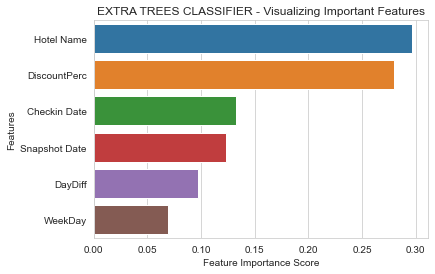

In [ ]:
print_influence_graph(clf_et)

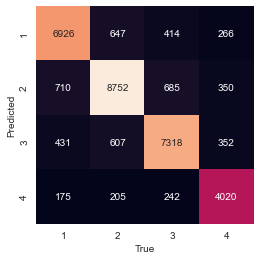

In [ ]:
print_confusion_matrix(clf_et)

FP '(false positive)' EXTRA TREES CLASSIFIER =  [1327 1745 1390  622]
FN '(false negative)' EXTRA TREES CLASSIFIER =  [1316 1459 1341  968]
TP '(true positive)' EXTRA TREES CLASSIFIER =  [6926 8752 7318 4020]
TN '(true negative)' EXTRA TREES CLASSIFIER =  [22531 20144 22051 26490]
Accuracy score for EXTRA TREES CLASSIFIER =  0.814988290237396
Recall for EXTRA TREES CLASSIFIER =  0.841619937694704
Precision for EXTRA TREES CLASSIFIER =  0.8419555258822666
ROC for EXTRA TREES CLASSIFIER =  0.9593903051025595


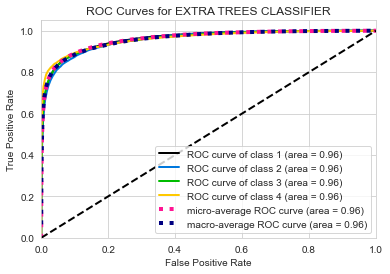

In [ ]:
print_few_methods_score(clf_et)
print_roc_curves(clf_et)

##### **Conclusions for ExtraTreesClassifier.**
*  The accuracy ROC, Recall, Precision, scores are very good.

*   The most influential parameters in the decision is discount price and the name of the hotel and it also conforms to the logic that a discount is in accordance with the policy of each hotel.

*   For the parameters within the algorithm itself we found that the parameter that most affects the result is the **n_estimators**. The other parameters do not affect to such an extent that it is worth changing them and therefore most of them remained in the default state.

* In the **Conclusions** part we explain the significance of the results of the statistical indices.

* It can be seen that although the algorithm does not bootstrap observations and nodes are split on random splits **the results are relatively good and not much different from random forest**.

* We took a reasonable range of estimators because we did not want it to be overfitting.

### **KNeighborsClassifier**
In KNN, K is the number of nearest neighbors. The number of neighbors is the core deciding factor.

In [ ]:
results_map['KNeighborsClassifier'] = clf_kn = get_best_clf('KNeighborsClassifier')

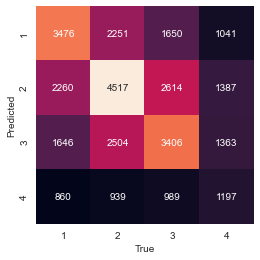

In [ ]:
print_confusion_matrix(clf_kn)

FP '(false positive)' KNEIGHBORSCLASSIFIER =  [4942 6261 5513 2788]
FN '(false negative)' KNEIGHBORSCLASSIFIER =  [4766 5694 5253 3791]
TP '(true positive)' KNEIGHBORSCLASSIFIER =  [3476 4517 3406 1197]
TN '(true negative)' KNEIGHBORSCLASSIFIER =  [18916 15628 17928 24324]
Accuracy score for KNEIGHBORSCLASSIFIER =  0.3833880793146007
Recall for KNEIGHBORSCLASSIFIER =  0.392398753894081
Precision for KNEIGHBORSCLASSIFIER =  0.38902451975432967
ROC for KNEIGHBORSCLASSIFIER =  0.6295753347303013


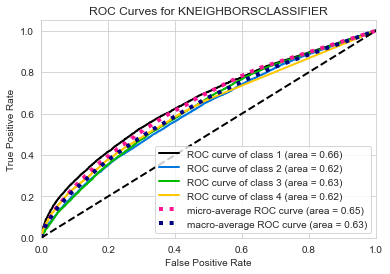

In [ ]:
print_few_methods_score(clf_kn)
print_roc_curves(clf_kn)

##### **Conclusions for KNeighborsClassifier.**
*   The accuracy ROC, Recall, Precision, scores are bad.

* To achieve a good result we go through a certain range of neighbors but for this algorithm it seems that it is not enough to give a good result [in our case].

* In the **Conclusions** part we explain the significance of the results of the statistical indices.

### **Now we will try a few more algorithms, in addition we will try more methods to deal with the fact that the target class is unbalanced.**

### **Resampling** 
Now I will try to do resampling and then run the best and worst algorithm and see if there is a change in the results.

In [ ]:
df_upsampled = upload_df(r'./Dataset/upsampled_classification_data.csv')

,Snapshot Date,Checkin Date,DayDiff,Hotel Name,WeekDay,DiscountPerc,Discount Code
0,0.0,0.0,1,0.403255,0.333333,2.375156,2
1,0.0,0.0,1,0.477396,0.333333,1.795402,2
2,0.0,0.0,1,0.591320,0.333333,2.579217,2
3,0.0,0.0,1,0.616637,0.333333,0.994252,2
4,0.0,0.0,1,0.652803,0.333333,2.956512,1


In [ ]:
features = list(df_upsampled.drop('Discount Code', axis = 1, inplace = False))
y = df_upsampled['Discount Code']
X = df_upsampled[features]
# Split and make Classifiers.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

[08:54:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:55:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:55:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:55:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_

[09:04:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:04:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:05:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


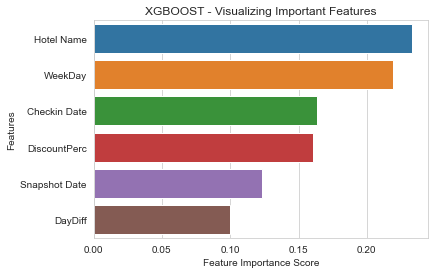

FP '(false positive)' XGBOOST =  [1021 1216 1071  701]
FN '(false negative)' XGBOOST =  [1008 1373 1158  470]
TP '(true positive)' XGBOOST =  [9164 8710 8935 9853]
TN '(true negative)' XGBOOST =  [29478 29372 29507 29647]
Accuracy score for XGBOOST =  0.8792901826881921
Recall for XGBOOST =  0.9014285363035086
Precision for XGBOOST =  0.9011359603352029
ROC for XGBOOST =  0.9806048451989372


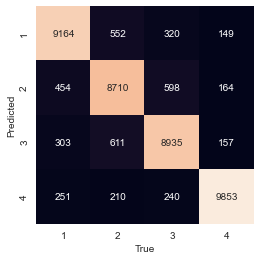

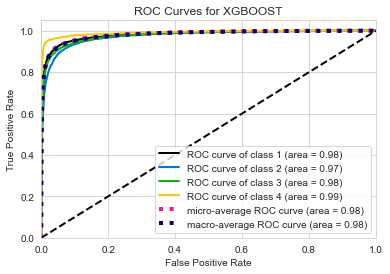

In [ ]:
# Try for the best algorithm we found.
results_map['XGBoost_resambled'] = clf_xgb_r = get_best_clf('XGBoost')
print_influence_graph(clf_xgb_r)
print_confusion_matrix(clf_xgb_r)
print_few_methods_score(clf_xgb_r)
print_roc_curves(clf_xgb_r)

FP '(false positive)' NAIVE_BAYES =  [8295 4570 8734 7087]
FN '(false negative)' NAIVE_BAYES =  [6628 8281 6576 7201]
TP '(true positive)' NAIVE_BAYES =  [3544 1802 3517 3122]
TN '(true negative)' NAIVE_BAYES =  [22204 26018 21844 23261]
Accuracy score for NAIVE_BAYES =  0.29297031753414327
Recall for NAIVE_BAYES =  0.2946817142435642
Precision for NAIVE_BAYES =  0.2938408355332371
ROC for NAIVE_BAYES =  0.5592062512903514


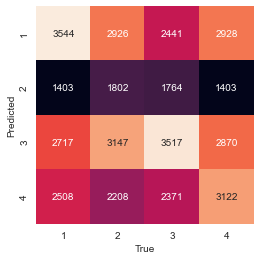

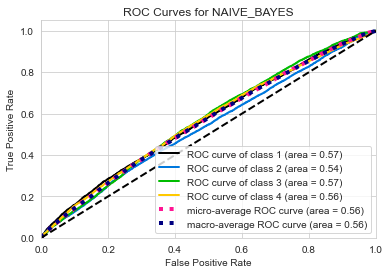

In [ ]:
# Try for the worst algorithm we found.
results_map['Naive Bayes resambled'] = clf_gnb_r = get_best_clf('naive_bayes')
print_confusion_matrix(clf_gnb_r)
print_few_methods_score(clf_gnb_r)
print_roc_curves(clf_gnb_r)

In [ ]:
# Now try for  a neural network.
# Now we will prepare our data for a neural network.
df_upsampled_copy = df_upsampled.copy()
features_n = list(df_upsampled_copy.drop('Discount Code', axis = 1, inplace = False))
y_n = to_categorical(df_upsampled_copy["Discount Code"])
X_n = df_upsampled_copy[features_n]/df_upsampled_copy[features_n].max()
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_n, y_n, test_size=0.30)

In [ ]:
# Activate the neural network after resambeld.
results_map['Neural network Resambeld'] = model_nn_r = get_best_nn('Neural network resambeld')

Epoch 1/100
949/949 [==============================] - 45s 46ms/step - loss: 1.3539 - accuracy: 0.4271 - val_loss: 1.3088 - val_accuracy: 0.3820
Epoch 2/100
949/949 [==============================] - 44s 46ms/step - loss: 1.2875 - accuracy: 0.4002 - val_loss: 1.2731 - val_accuracy: 0.4101
Epoch 3/100
949/949 [==============================] - 44s 46ms/step - loss: 1.2572 - accuracy: 0.4249 - val_loss: 1.2578 - val_accuracy: 0.4255
Epoch 4/100
949/949 [==============================] - 44s 46ms/step - loss: 1.2326 - accuracy: 0.4410 - val_loss: 1.2347 - val_accuracy: 0.4413
Epoch 5/100
949/949 [==============================] - 44s 46ms/step - loss: 1.2087 - accuracy: 0.4564 - val_loss: 1.2079 - val_accuracy: 0.4545
Epoch 6/100
949/949 [==============================] - 44s 46ms/step - loss: 1.1845 - accuracy: 0.4739 - val_loss: 1.1872 - val_accuracy: 0.4714
Epoch 7/100
949/949 [==============================] - 44s 46ms/step - loss: 1.1608 - accuracy: 0.4906 - val_loss: 1.1655 - val_ac

Epoch 57/100
949/949 [==============================] - 44s 46ms/step - loss: 0.4496 - accuracy: 0.8296 - val_loss: 0.8158 - val_accuracy: 0.7404
Epoch 58/100
949/949 [==============================] - 44s 46ms/step - loss: 0.4459 - accuracy: 0.8311 - val_loss: 0.8363 - val_accuracy: 0.7374
Epoch 59/100
949/949 [==============================] - 44s 46ms/step - loss: 0.4381 - accuracy: 0.8346 - val_loss: 0.8112 - val_accuracy: 0.7461
Epoch 60/100
949/949 [==============================] - 43s 46ms/step - loss: 0.4293 - accuracy: 0.8393 - val_loss: 0.8422 - val_accuracy: 0.7336
Epoch 61/100
949/949 [==============================] - 43s 46ms/step - loss: 0.4297 - accuracy: 0.8368 - val_loss: 0.8075 - val_accuracy: 0.7489
Epoch 62/100
949/949 [==============================] - 43s 46ms/step - loss: 0.4248 - accuracy: 0.8395 - val_loss: 0.8296 - val_accuracy: 0.7459
Epoch 63/100
949/949 [==============================] - 43s 46ms/step - loss: 0.4195 - accuracy: 0.8409 - val_loss: 0.8344 -

In [ ]:
print_few_methods_score(model_nn_r)
#print_confusion_matrix(model_nn_r)
print(model_nn_r.conf_mat)

FP '(false positive)' NEURAL NETWORK RESAMBELD =  [2529 2541 1889 1906]
FN '(false negative)' NEURAL NETWORK RESAMBELD =  [2124 2806 2625 1310]
TP '(true positive)' NEURAL NETWORK RESAMBELD =  [8036 7282 7614 8874]
TN '(true negative)' NEURAL NETWORK RESAMBELD =  [27982 28042 28543 28581]
Accuracy score for NEURAL NETWORK RESAMBELD =  0.7820314
Recall for NEURAL NETWORK RESAMBELD =  0.7675985
Precision for NEURAL NETWORK RESAMBELD =  0.79563177
ROC for NEURAL NETWORK RESAMBELD =  0.9379939
[[8036 1006  562  556]
 [1199 7282  932  675]
 [ 861 1089 7614  675]
 [ 469  446  395 8874]]


##### **Conclusions after resampling.**
*   We can see that the statistical indices accuracy ROC, Recall, Precision, scores improved in the algorithms they were good at in the first place but got worse at algorithms where they were low at first. In the **Conclusions** we will explain more why in our opinion this phenomenon occurs.


## **Graph to compare the different classification algorithms**

In [ ]:
comp_df = pd.DataFrame(columns = ('Method', 'Auccuracy Score', 'Recall', 'Precision', 'ROC'))

for i in results_map:
    row = {'Method': i, 'Auccuracy Score': results_map[i].score.auccuracy, 'Recall': results_map[i].score.recall,
          'Precision': results_map[i].score.precision, 'ROC': results_map[i].score.roc,'y_pred':results_map[i].y_pred}
    comp_df = comp_df.append(row, ignore_index=True)

comp_df    

,Method,Auccuracy Score,Recall,Precision,ROC,y_pred
0,gini,0.782157,0.811931,0.811985,0.872897,"[4, 3, 3, 1, 3, 3, 2, 2, 3, 1, 3, 4, 2, 3, 3, ..."
1,entropy,0.787618,0.817975,0.818036,0.876689,"[4, 3, 3, 1, 2, 3, 3, 2, 3, 1, 3, 4, 2, 3, 2, ..."
2,random forest,0.825763,0.852025,0.852498,0.964768,"[4, 3, 3, 1, 3, 3, 2, 2, 3, 1, 3, 4, 2, 3, 2, ..."
3,Naive Bayes,0.318753,0.320218,0.302048,0.555997,"[2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 3, 2, 2, 2, 2, ..."
4,XGBoost,0.839635,0.867477,0.867823,0.971560,"[4, 3, 3, 1, 2, 3, 2, 2, 2, 1, 3, 4, 2, 2, 2, ..."
5,Neural network,0.724268,0.704891,0.743673,0.913389,"[[6.114702e-36, 0.95833576, 0.03754093, 0.0038..."
6,Extra Trees Classifier,0.814988,0.841620,0.841956,0.959390,"[4, 3, 3, 2, 3, 3, 2, 2, 2, 1, 3, 4, 2, 3, 2, ..."
7,KNeighborsClassifier,0.383388,0.392399,0.389025,0.629575,"[2, 2, 3, 1, 3, 3, 3, 3, 2, 1, 3, 2, 1, 4, 4, ..."
8,XGBoost_resambled,0.879290,0.901429,0.901136,0.980605,"[4, 4, 4, 2, 2, 4, 1, 4, 4, 1, 3, 3, 1, 1, 2, ..."
9,Naive Bayes resambled,0.292970,0.294682,0.293841,0.559206,"[1, 4, 1, 1, 3, 4, 4, 4, 3, 1, 3, 3, 4, 1, 4, ..."


Text(0.5, 1.0, 'Comparison graph')

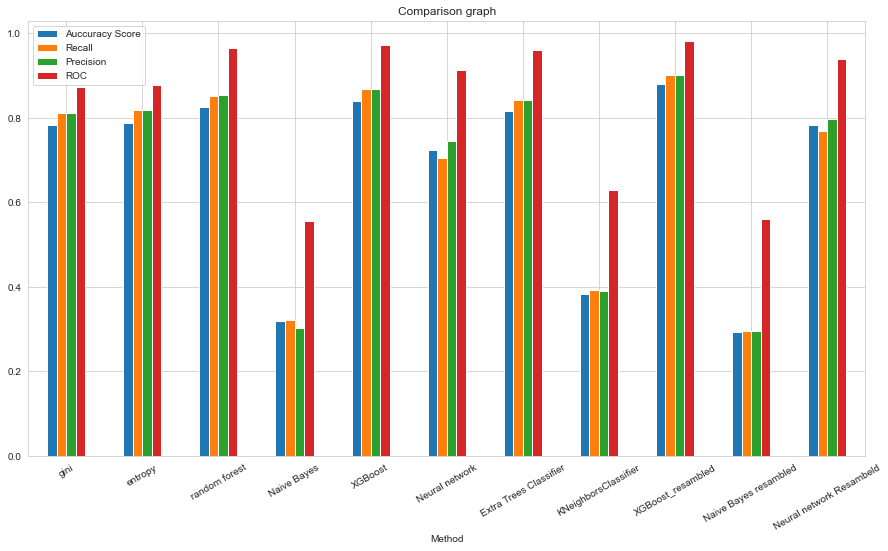

In [ ]:
ax = comp_df.plot.bar(x='Method', rot=30, figsize=(15,8))
ax.set_title('Comparison graph')

####  **An explanation of the meaning of the results we got and the differences between Algorithms performance.**

* According to the graph our algorithms in terms of performance and accuracy [in part IV we explained what these statistical metrics mean] are ranked in the following order [from high to low]: XGBoost_resambled, XGBoost, random forest, extra trees classifier, Neural network Resambeld, entropy, gini, Neural network, KNeghborsClassifier, naive bayes, naive bayes resambled.

#### **An explanation why these differences exist when they are significant**

* We can see a difference between ordinary decision trees and random forest and the explanation for that is simple: A decision tree is built on an entire dataset, using all the features of interest, whereas a random forest randomly selects observations/rows and specific features to build multiple decision trees from and then averages the results. Because of that this algorithm works more accurately than a standard decision tree as we can see in the results. [The exact same explanation is also for the extra trees classifier that we can see whose results are almost identical to the results of random forest].

* You can see a slight difference between random forest and XGBoost in our opinion the explanation is: Random forest is what we call to bagging applied to decision trees (reduce variance) through bagging [This keeps the model relatively stable even if the data changes], XGBoost based on **Boosting**. Boosting reduces variance, and also reduces bias. It reduces variance because you are using multiple models (bagging). It reduces bias by training the subsequent model by telling him what errors the previous models made (the boosting part). It can be assumed that the addition of the Boosting makes this algorithm better than the random forest.

#### **An explanation of the algorithms with the lowest results.**
**We have seen that for the naive bayes, KNeghborsClassifier algorithms we get very low results now we will explain why:**

* Naive bayes - The naive assumption of the algorithm [from this assumption derives the name of the algorithm] is that there is no dependence between properties / features of the classified objects when their classification is already known. **In our case it can be said that this assumption is wrong there is a connection between the different features** and this assumption of the algorithm causes it to give us very bad results.

* KNeghborsClassifier -  An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors. In our case it does not work well because it is not possible to give a classification in this case based on the neighbor closest to you but on other data [as the other algorithms choose] .. **"Near neighbor" does not indicate the same discount code.**

####  **An explanation of the "phenomenon" that occurs when resampling data is performed.**

* We have seen that after resampling the data the algorithms that gave good results in the first place get better and those that gave bad results become worse and the explanation for this in our opinion is simple: The best algorithms reads the data correctly in the first place and knows to give answers almost always correct and after resampling the data is more balanced so they bring better results, but on the other hand the worst algorithms in the first place does not fit this type of data and the reason it gets worse is that the more balanced the target class its chance of giving a correct answer decreases because when it was unbalanced maybe by chance it would fall on a correct answer.


## **the influence level of each feature on the algorithm decision.**
*  In all the algorithms we presented a graph that shows the level of influence of each feature on the decision of the algorithm. In each summary of the algorithm we also explained in more detail the parameters that influenced the decision. 

* In order to evaluate how much each parameter affected the algorithm we will print a graph of the accuracy score of some of the parameters and thus see how much the parameter affected the accuracy. [We will check the parameters according to the set of accuracy scores we kept for each parameter in each of the algorithms].

In [ ]:
def print_param_acc_history(params_range, set_params, x1,x2,x3,x4,x5,name): 

    for i in range(0,5):
        for j in range(len(params_range[i])):
            if params_range[i][j] is None:
                params_range[i][j] = 'default'
    fig,  ((ax1, ax2 ,ax3, ax4, ax5)) = plt.subplots(1, 5, figsize=(15,3))
    ax1.plot(params_range[0],x1)
    ax1.set_title('Acc ' + set_params[0] + ' ' + name, fontdict={'fontsize': 8, 'fontweight': 'medium'})
    ax2.plot(params_range[1],x2, 'tab:orange')
    ax2.set_title('Acc ' + set_params[1] + ' ' + name, fontdict={'fontsize': 8, 'fontweight': 'medium'})
    ax3.plot(params_range[2],x3, 'tab:green')
    ax3.set_title('Acc ' + set_params[2] + ' ' + name, fontdict={'fontsize': 8, 'fontweight': 'medium'})
    ax4.plot(params_range[3],x4, 'tab:red')
    ax4.set_title('Acc ' + set_params[3] + ' ' + name, fontdict={'fontsize': 8, 'fontweight': 'medium'})
    ax5.plot(params_range[4],x5, 'tab:grey')
    ax5.set_title('Acc ' + set_params[4] + ' ' + name, fontdict={'fontsize': 8, 'fontweight': 'medium'})


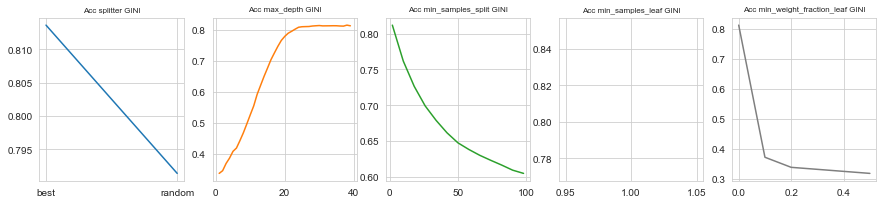

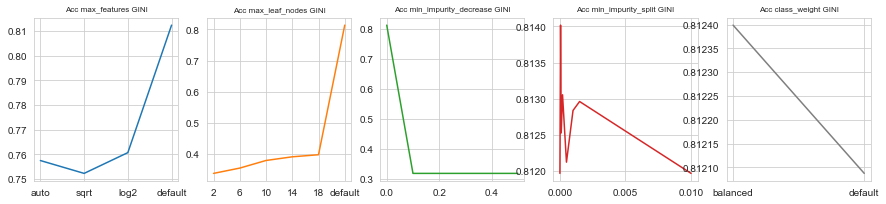

In [ ]:
# check on gini classifier parameters.

print_param_acc_history(params_range_tree[:5], set_tree_params[:5],clf_gini.ph.acc_s,clf_gini.ph.acc_md,clf_gini.ph.acc_mss,
                        clf_gini.ph.acc_msl,clf_gini.ph.acc_mwfl, 'GINI')
print_param_acc_history(params_range_tree[5:10], set_tree_params[5:10],clf_gini.ph.acc_mf,clf_gini.ph.acc_mln,clf_gini.ph.acc_mid,
                        clf_gini.ph.acc_mis,clf_gini.ph.acc_cw, 'GINI')

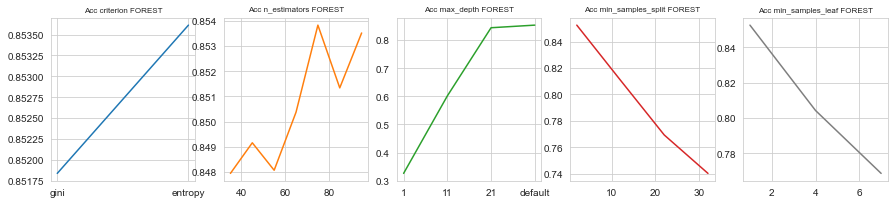

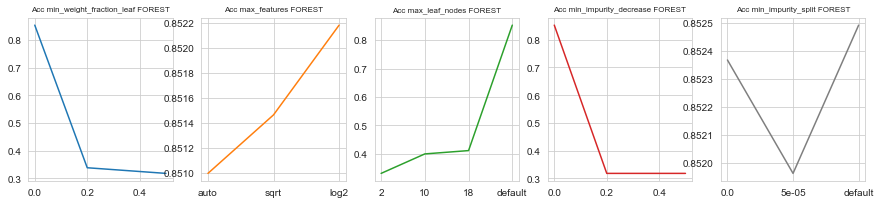

In [ ]:
# check on random forest classifier parameters.

print_param_acc_history(params_range_forest[:5], set_forest_params[:5],clf_rf.ph.acc_c,clf_rf.ph.acc_ne,clf_rf.ph.acc_md,
                        clf_rf.ph.acc_mss,clf_rf.ph.acc_msl, 'FOREST')
print_param_acc_history(params_range_forest[5:10], set_forest_params[5:10],clf_rf.ph.acc_mwfl,clf_rf.ph.acc_mf,clf_rf.ph.acc_mln,
                        clf_rf.ph.acc_mid,clf_rf.ph.acc_mis, 'FOREST')

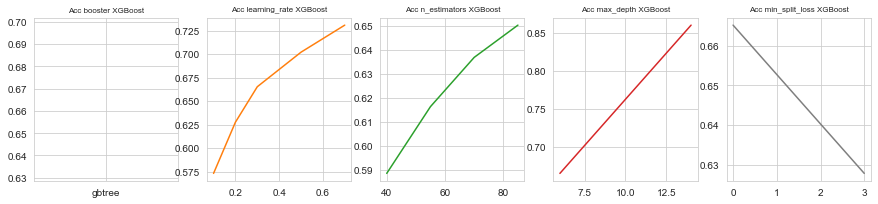

In [ ]:
# check on xgboost classifier parameters.

print_param_acc_history(params_range_xgboost[:5], set_xgboot_params[:5],clf_xgb.ph.acc_bs, clf_xgb.ph.acc_lr, clf_xgb.ph.acc_ne,
                        clf_xgb.ph.acc_md, clf_xgb.ph.acc_mslo, 'XGBoost')

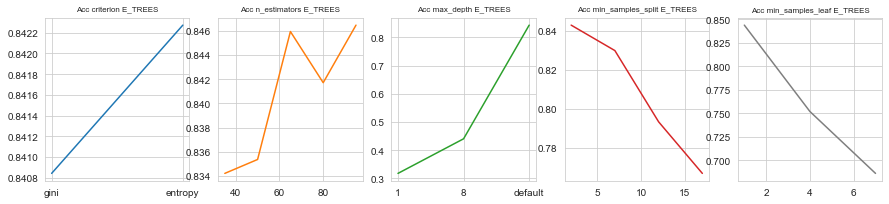

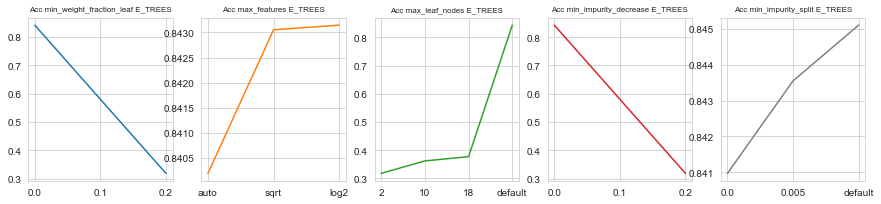

In [ ]:
# check on Extra Trees classifier parameters.

print_param_acc_history(params_range_extrat[:5], set_extrat_params[:5],clf_et.ph.acc_c, clf_et.ph.acc_ne, clf_et.ph.acc_md,
                        clf_et.ph.acc_mss, clf_et.ph.acc_msl, 'E_TREES')
print_param_acc_history(params_range_extrat[5:10], set_extrat_params[5:10],clf_et.ph.acc_mwfl, clf_et.ph.acc_mf, clf_et.ph.acc_mln,
                        clf_et.ph.acc_mid, clf_et.ph.acc_mis, 'E_TREES')

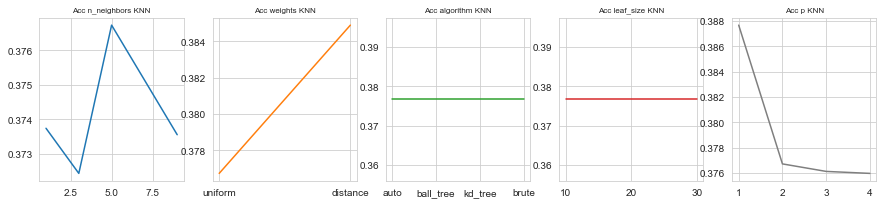

In [ ]:
# check on KNeighbors classifier parameters.

print_param_acc_history(params_range_knn[:5], set_knn_params[:5],clf_kn.ph.acc_nn, clf_kn.ph.acc_w, clf_kn.ph.acc_a,
                        clf_kn.ph.acc_ls, clf_kn.ph.acc_p, 'KNN')

## **Explanation: the significance of the results of the statistical indices.**
For each algorithm we have printed out all the statistical indices and now we will explain what each index means and what it means for a high / low result. 

Classification accuracy score. It is the number of correct predictions made divided by the total number of predictions made, multiplied by 100 to turn it into a percentage. the best score is 100% accuracy. This is not the best measure there is because it does not measure the success of the algorithm per class.

Precision is the number of True Positives divided by the number of True Positives and False Positives. Put another way, it is the number of positive predictions divided by the total number of positive class values predicted. Precision can be thought of as a measure of a classifiers exactness. Because of the explanation above **A low precision can also indicate a large number of False Positives.**

Recall is the number of True Positives divided by the number of True Positives and the number of False Negatives. Put another way it is the number of positive predictions divided by the number of positive class values in the test data. Recall can be thought of as a measure of a classifiers completeness. Because of the explanation above **A low recall indicates many False Negatives.**

[Precision can be seen as a measure of quality, and recall as a measure of quantity. Higher precision means that an algorithm returns more relevant results than irrelevant ones, and high recall means that an algorithm returns most of the relevant results (whether or not irrelevant ones are also returned).]

High scores for both **[Recall & Precision]** show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall). A classifier with high recall but low precision returns many results, but most of its predicted labels are incorrect when compared to the training labels.

ROC is a very important metric to differentiate between the various algorithms. The value of the area under the roc curve the AUC value lies between 0.5 to 1 where 0.5 denotes a bad classifer and 1 denotes an excellent classifier. AUC provides an aggregate measure of performance across all possible classification thresholds. The ROC curve is a graph with: The x-axis showing 1 – specificity (= false positive fraction = FP/(FP+TN)) The y-axis showing sensitivity (= true positive fraction = TP/(TP+FN)).

Accuracy vs ROC AUC. The first big difference is that you calculate accuracy on the predicted classes while you calculate ROC AUC on predicted scores that means if our problem is highly imbalanced we get a really high accuracy score by simply predicting that all observations belong to the majority class so in such a case the ROC will better evaluate the performance of the various algorithms. **[In the case of our data the indices are indeed not so balanced so the algorithms that will give us the best ROC performance are the best for classification in our case]**


